### GBM reflectance project
#### 3rd Jan 2022 - read in images
#### 5th Jan 2022 - added CM code, converted images to grayscale

In [279]:
import numpy as np
import pandas as pd
import scipy.integrate
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
import time
import multiprocessing as mp
import os

from scipy.stats import zscore

from sklearn.manifold import TSNE
from sklearn.mixture import BayesianGaussianMixture

from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from scipy import ndimage

import phenograph as pg
import random

In [280]:
path_python = '/Users/4470526/Downloads/Projects/GBM_SCRIPPS/Prelim_ImageSet_Moffitt/test/'

#warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


reading in FOV 0
File name:  IF_Case05RecuA2_Broad_0001_C001T001.tif
(800, 800)
reading in FOV 1
File name:  IF_Case05RecuA2_Broad_0001_C002T001.tif
(800, 800)
reading in FOV 2
File name:  IF_Case05RecuA2_Broad_0001_C003T001.tif
(800, 800)
reading in FOV 3
File name:  IF_Case05RecuA2_Broad_0001_C004T001.tif
(800, 800)
reading in FOV 4
File name:  IF_Case05RecuA2_Broad_0001_C005T001.tif
(800, 800)
Preprocessing the image
0


Text(0.5, 1.0, 'thresholded image overall')

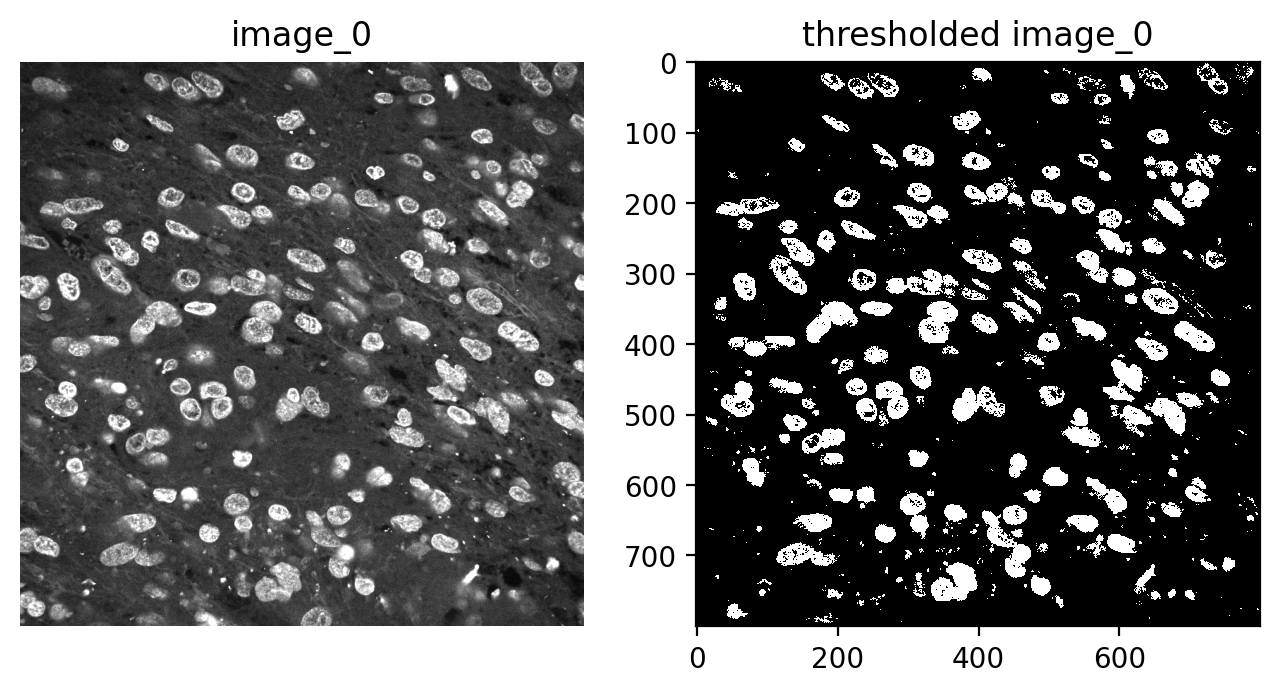

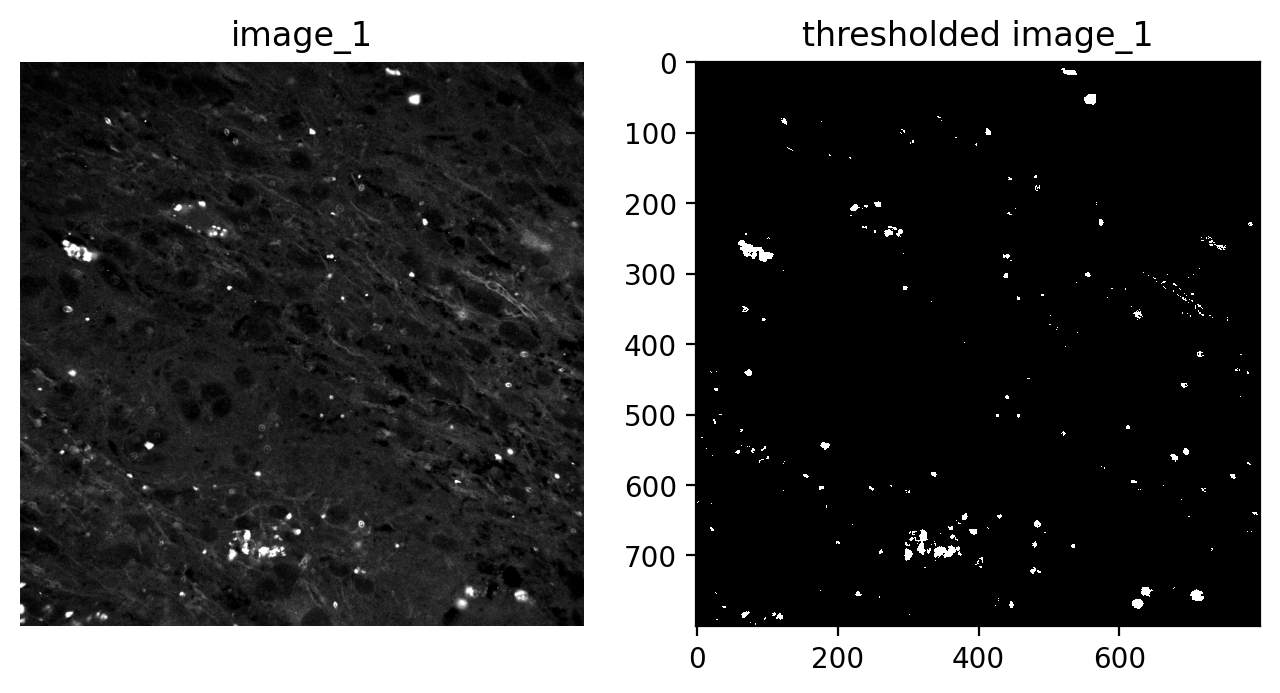

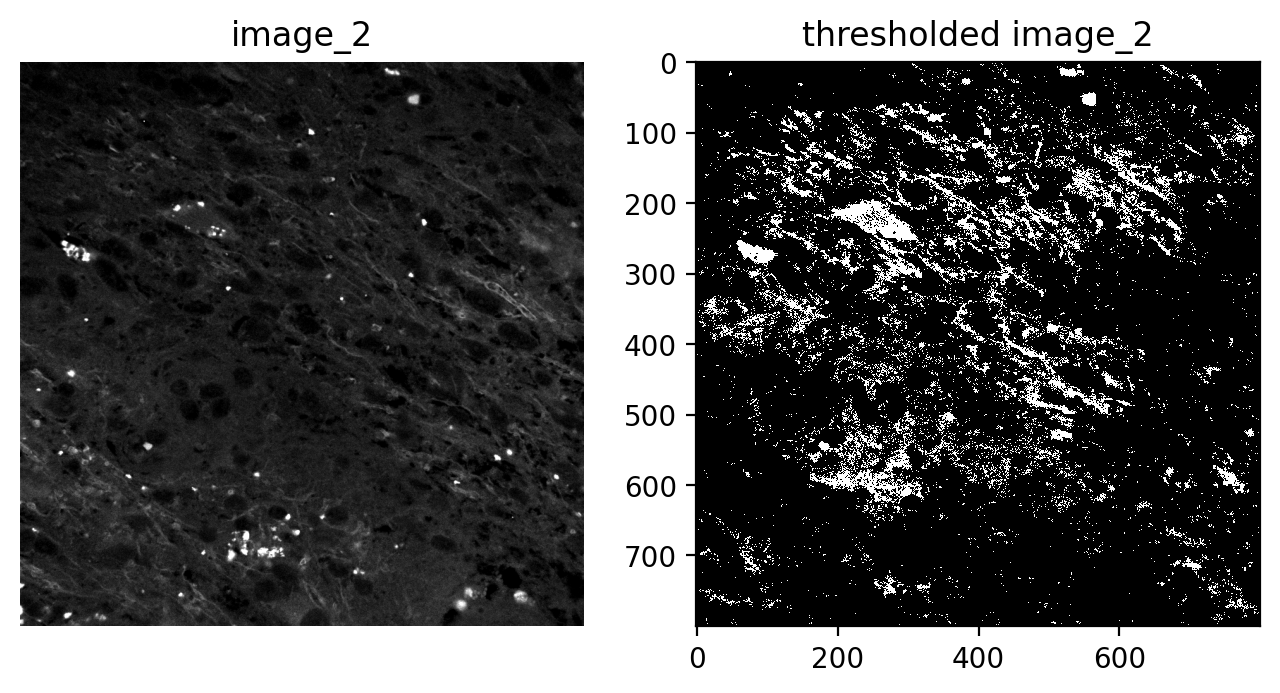

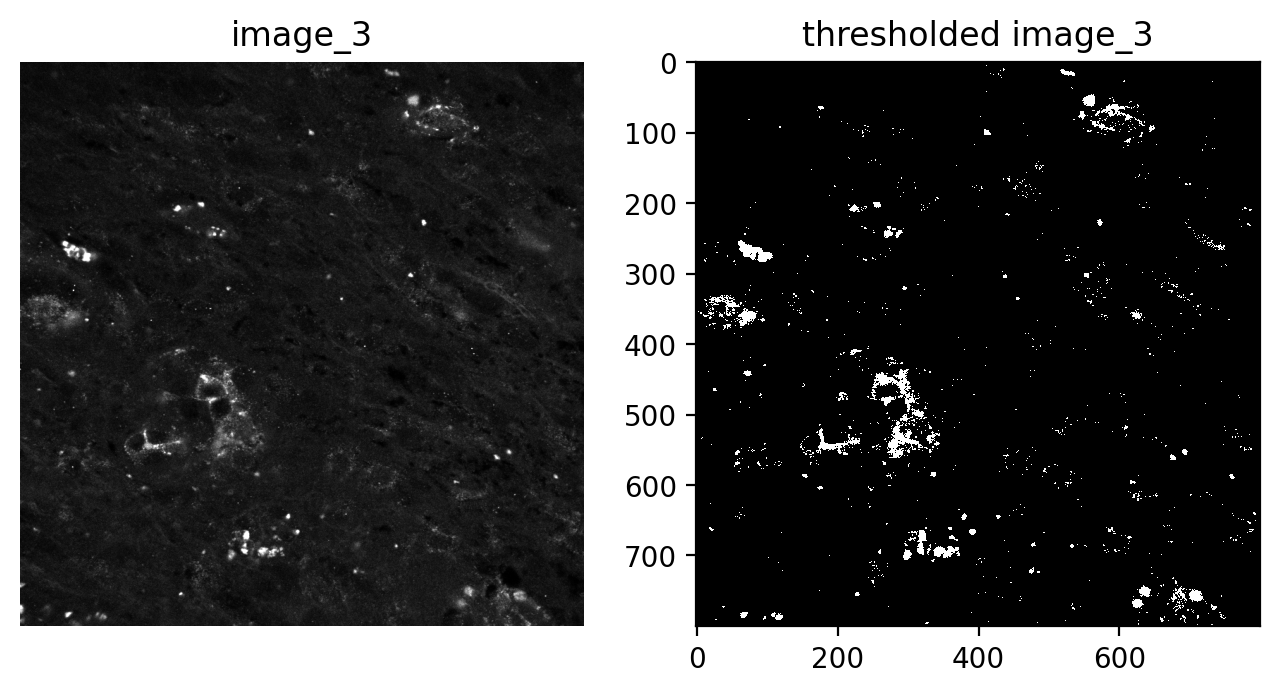

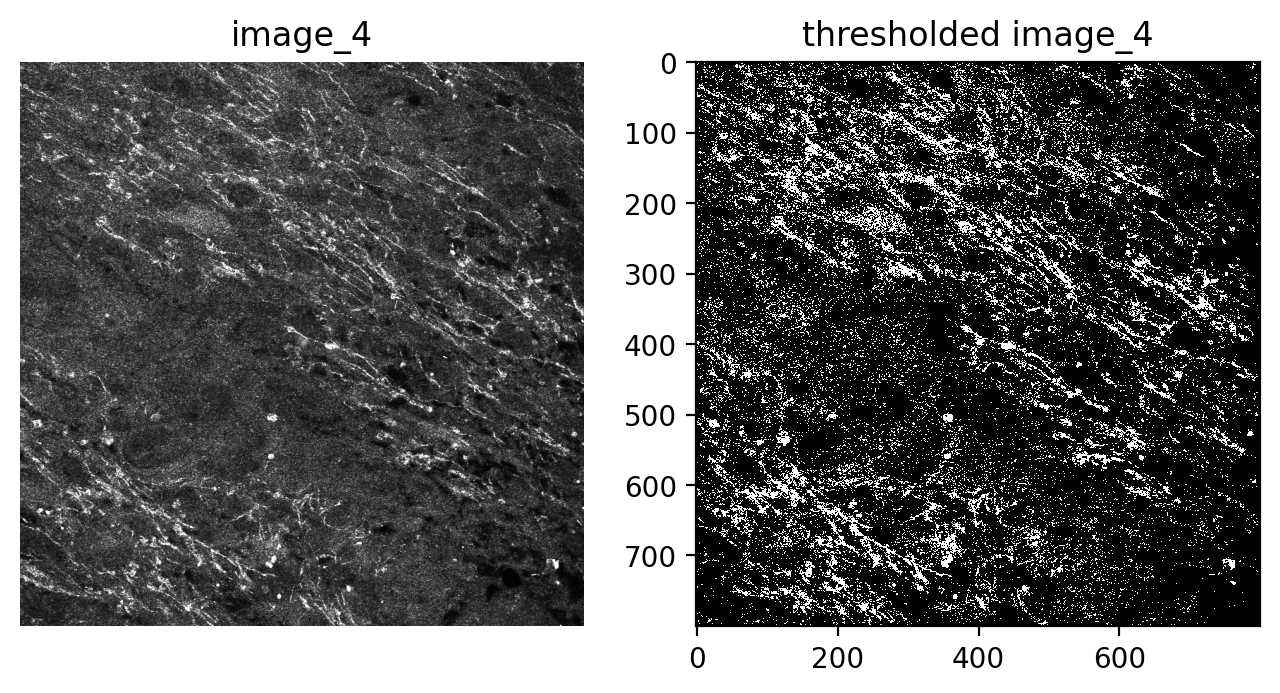

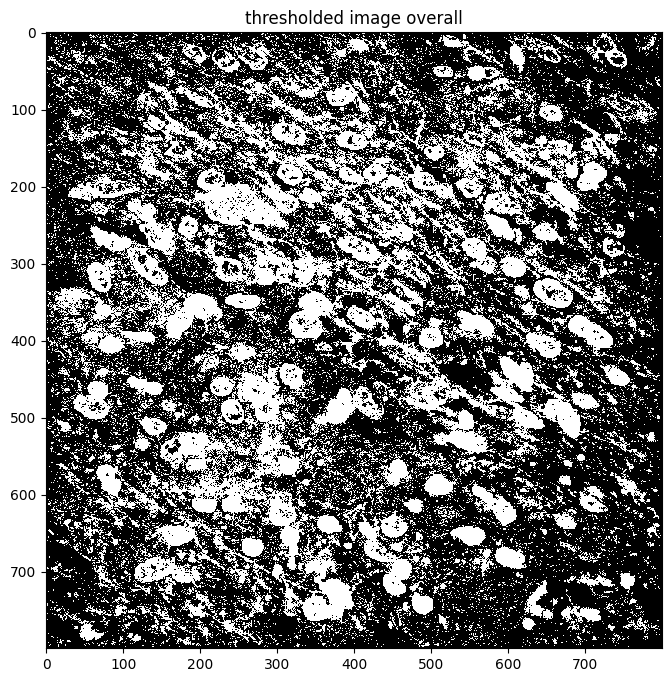

In [297]:
# Get and resize test images

IMG_CHANNELS_1 = 5

IMG_WIDTH_2 = IMG_HEIGHT_2 = 256

path_data = os.path.join(path_python,'images/')

num_colour = 20
cm = plt.cm.get_cmap('tab20', num_colour)

dpi_set = 100

count = 0

pat_num = []


thresh_m = []

image_all_1 = []

raw_images = []

for fname in sorted(os.listdir(path_data)):  
    print('reading in FOV '+ str(count))
    print('File name: ',fname)
    #im = io.imread(fname)
    im = io.imread(os.path.join(path_data + fname),plugin='matplotlib',as_gray=True)
    print (im.shape)
    
    #im = im[:,:,0]
    
    raw_images.append(im)
    
    IMG_HEIGHT_1 = im.shape[0]
    IMG_WIDTH_1 = im.shape[1]


    
    
    thresh_m.append(threshold_otsu(im))
    

    
    
    bw = closing(im > thresh_m[count], square(1))

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    image_all_1.append(cleared)

    '''
    plt.figure((i+count*2+1),dpi=100, figsize=(10,10))
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title('image_'+str(count))

    plt.figure((i+2+count*2),dpi=100, figsize=(10,10))
    plt.imshow(cleared, 'gray', interpolation='none')
    plt.title('thresholded image_'+str(count))
    '''
    plt.figure(figsize=(8,8),dpi= 200)
    plt.subplot(1,2,1)
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title('image_'+str(count))
    plt.subplot(1,2,2)
    plt.imshow(cleared, 'gray', interpolation='none')
    plt.title('thresholded image_'+str(count))
    
    count = count + 1
    
    

print('Preprocessing the image')
# to clean all the frames per image

image = sum(image_all_1)
# apply threshold
thresh = threshold_otsu(image)
print(thresh)
bw = closing(image > thresh, square(1))
    
# remove artifacts connected to image border
cleared4 = clear_border(bw)

plt.figure((i+3+count),dpi=100, figsize=(8,8))
plt.imshow(cleared4, 'gray', interpolation='none')
plt.title('thresholded image overall')

        
  
    

    

In [288]:
thresh

0

In [289]:
thresh_m

[0.03671268382352941,
 0.11950976562499999,
 0.08109804610906862,
 0.1906966207107843,
 0.30539148667279414]

In [290]:
seg_im = io.imread(os.path.join(path_python + 'IF_Case05RecuA2_Broad_0001_C001T001_SegmentedBinary.tiff'))

In [291]:
seg_im_obj = io.imread(os.path.join(path_python + 'IF_Case05RecuA2_Broad_0001_C001T001_SegmentedObject.tiff'))

Text(0.5, 1.0, 'threshold composite image')

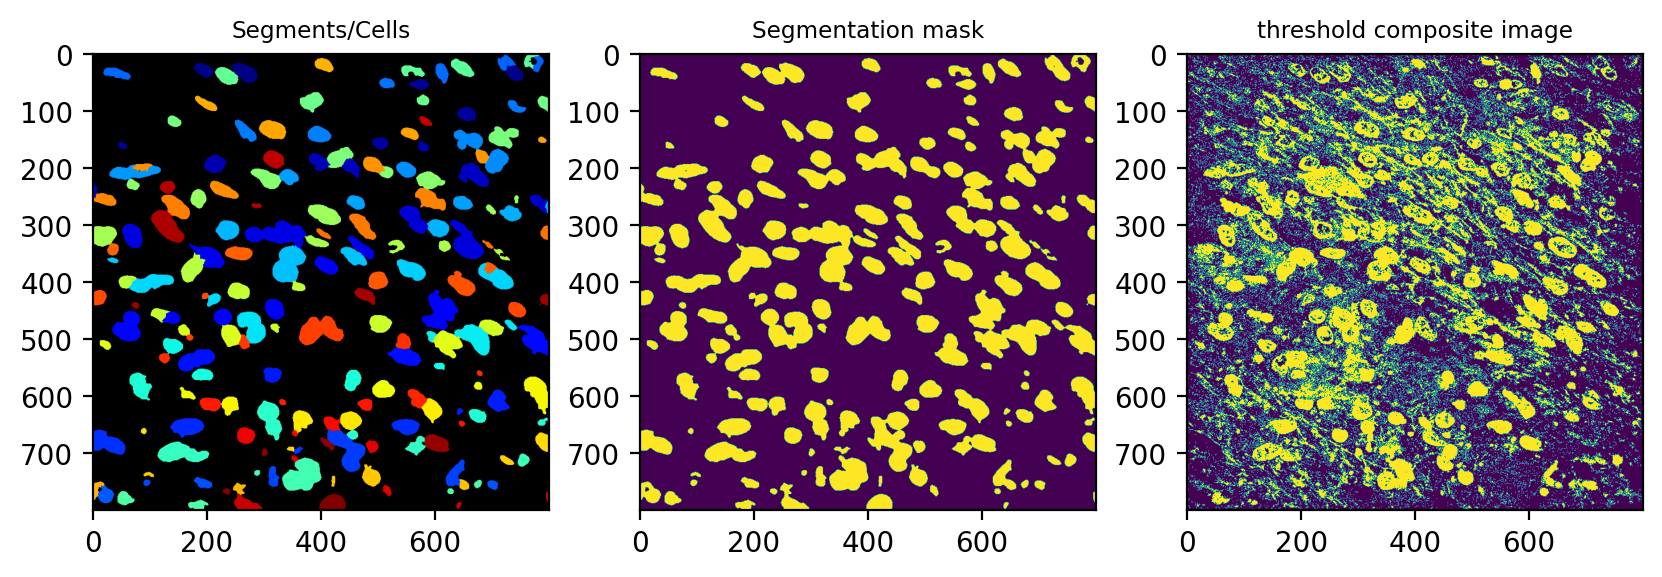

In [292]:
plt.figure(figsize=(10,10),dpi= 200)
plt.subplot(1,3,1)
plt.imshow(seg_im_obj)
plt.title("Segments/Cells",fontsize='small')
plt.subplot(1,3,2)
plt.imshow(seg_im)
plt.title("Segmentation mask",fontsize='small')
plt.subplot(1,3,3)
plt.imshow(cleared4)
plt.title("threshold composite image",fontsize='small')

In [293]:
GBM_CM_list = []
cells_per_FOV = []
cent_per_FOV = []

label_im_st_list = []
# construct the count matrix
print('Construct the Count matrix')
label_im_st, nb_labels_st = ndimage.label(seg_im_obj) #153 objects
sizes = ndimage.sum(seg_im_obj, label_im_st, range(nb_labels_st+1))
label_im_st_list.append(label_im_st)


region_cell = []
region_area = []

cent = []

Construct the Count matrix


In [294]:
nb_labels_st

153

In [222]:
#########

## for each region in the segmentation mask, loop over each marker image and build the countmatrix based on 
## whether the value at that region is above that marker's Otsu threshold 

for i, region in enumerate(regionprops(label_im_st)): # for each of 153 objects, access the area/centroids
    print("i ",i)
    region_cell_temp = np.zeros(len(image_all_1))
    cent.append(region.centroid)

    region_area.append(region.area)
    print("region.area ",region.area)
    
    for marker in range(len(raw_images)):
        print("marker ",marker)
        val = 0
        im= raw_images[marker]
        for a in range(region.area):
            #print("region.area ",region.area)
            #val = im[marker][region.coords[a][0],region.coords[a][1]]+val
            if(raw_images[marker][region.coords[a][0],region.coords[a][1]] >= thresh_m[marker]):
                val = val + 1
        region_cell_temp[marker]=val
    region_cell.append(region_cell_temp/region.area)

GBM_CM_list.append(np.array(region_cell))

cells_per_FOV.append(nb_labels_st)
cent_per_FOV.append(cent)


i  0
region.area  1670
marker  0
marker  1
marker  2
marker  3
marker  4
i  1
region.area  1647
marker  0
marker  1
marker  2
marker  3
marker  4
i  2
region.area  1164
marker  0
marker  1
marker  2
marker  3
marker  4
i  3
region.area  2352
marker  0
marker  1
marker  2
marker  3
marker  4
i  4
region.area  3715
marker  0
marker  1
marker  2
marker  3
marker  4
i  5
region.area  598
marker  0
marker  1
marker  2
marker  3
marker  4
i  6
region.area  1146
marker  0
marker  1
marker  2
marker  3
marker  4
i  7
region.area  1632
marker  0
marker  1
marker  2
marker  3
marker  4
i  8
region.area  1296
marker  0
marker  1
marker  2
marker  3
marker  4
i  9
region.area  774
marker  0
marker  1
marker  2
marker  3
marker  4
i  10
region.area  463
marker  0
marker  1
marker  2
marker  3
marker  4
i  11
region.area  2901
marker  0
marker  1
marker  2
marker  3
marker  4
i  12
region.area  963
marker  0
marker  1
marker  2
marker  3
marker  4
i  13
region.area  1040
marker  0
marker  1
marker  

In [223]:
raw_images[marker][region.coords[a][0],region.coords[a][1]]

0.11735294117647059

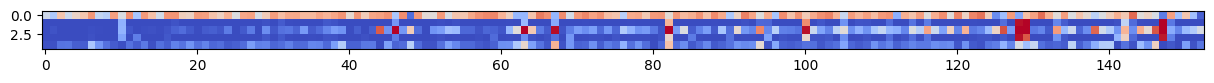

In [252]:
#plot the Count matrix 
plt.figure(figsize=(15,20))
plt.imshow(np.transpose(GBM_CM_list[0]),cmap='coolwarm')
#plt.colorbar()

In [235]:
plt.imshow(label_im_st[:,:,0])

In [276]:
# each object's area distribution
# a) as is
# b) histogram
plt.figure(figsize=(10,5),dpi= 100)
plt.subplot(1,2,1)
plt.plot(region_area,'b*')
plt.title("Area per segment",fontsize='small')
plt.subplot(1,2,2)
plt.hist(region_area,color='orchid')
plt.title("Histogram of object areas",fontsize='small')



print(np.histogram(region_area))


(array([91, 34, 16,  7,  0,  3,  1,  0,  0,  1]), array([   80. ,  1696.6,  3313.2,  4929.8,  6546.4,  8163. ,  9779.6,
       11396.2, 13012.8, 14629.4, 16246. ]))
